In [7]:
rootdir="C:/Users/awacs/Dropbox/HSPH/Quackenbush Lab/Thesis"

### Load these files for convenience

In [133]:
# setwd(rootdir)
# gene_degree_diff=unlist(read.table('degree_diff.rnk',row.names=1),use.names = T)
# sig.names=as.vector(unlist(read.table('280_signames.gsea')))
# gene_degree_diff=read.table('degree_diff.rnk')
# degree_diff=gene_degree_diff[,2]
# names(degree_diff)=gene_degree_diff[,1]

In [44]:
library(Matrix)
condor.qscore.modified <- function (condor.object) 
{
  if (is.null(condor.object$red.memb) | is.null(condor.object$blue.memb)) {
    stop("Community Memberships missing. Run condor.cluster or condor.modularity.max first!")
  }
  bo <- condor.object
  bo$blue.memb <- bo$blue.memb[order(bo$blue.memb[, "blue.names"]), 
                               ]
  bo$red.memb <- bo$red.memb[order(bo$red.memb[, "red.names"]), 
                             ]
  bo$Qcoms <- bo$Qcoms[order(bo$Qcoms[, "community"]), ]
  condor.object <- bo
  esub <- condor.object$edges
  reds = as.integer(factor(esub[, 1]))
  blues = as.integer(factor(esub[, 2]))
  if (ncol(esub) > 2) {
    weights <- esub[, 3]
  }
  else {
    weights <- rep(1, nrow(esub))
  }
  A = sparseMatrix(i = reds, j = blues, x = weights, dims = c(length(unique(reds)), 
                                                              length(unique(blues))), index1 = TRUE)
  if (nrow(A) < ncol(A)) {
    A <- t(A)
  }
  p = nrow(A)
  q = ncol(A)
  N = p + q
  ki = rowSums(A)
  dj = colSums(A)
  m = sum(ki)
  R1 = condor.object$red.memb
  T1 = condor.object$blue.memb
  r1 = cbind(as.numeric(factor(R1[, 1])), R1[, 2])
  t1 = cbind(as.numeric(factor(T1[, 1])), T1[, 2])
  Rtrans = sparseMatrix(i = r1[, 2], j = r1[, 1], x = 1, dims = c(max(r1[, 
                                                                         2]), length(unique(r1[, 1]))), index1 = TRUE)
  T2 = sparseMatrix(i = t1[, 1], j = t1[, 2], x = 1, dims = c(max(t1[, 
                                                                     1]), max(t1[, 2])), index1 = TRUE)
  Qcoms <- condor.object$Qcoms
  Qjk = vector(length = q)
  for (j in 1:max(t1[, 1])) {
    if (j%%1000 == 0) {
      print(paste(j, t1[j, ]))
    }
    Bj = A[, j] - (ki * dj[j])/m
    Qjk[j] = ((Rtrans[t1[j, 2], ] %*% Bj)/(2 * m))
  }
  Qik = vector(length = p)
  for (i in 1:max(r1[, 1])) {
    if (i%%1000 == 0) {
      print(i)
    }
    Bi = A[i, ] - (ki[i] * dj)/m
    Qik[i] = ((Bi %*% T2[, r1[i, 2]])/(2 * m))
  }
  condor.object$qscores = list(blue.qscore = data.frame(T1, 
                                                        Qjk), red.qscore = data.frame(R1, Qik))
  return(condor.object)
}



Attaching package: 'Matrix'

The following object is masked from 'package:IRanges':

    expand



## Install needed packages

In [ ]:
ipak <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg))
        install.packages(new.pkg, dependencies = TRUE, repos = "http://cran.us.r-project.org")
    sapply(pkg, require, character.only = TRUE)
}
# install needed packages
# usage
packages <- c("lawstat","igraph","devtools","data.table","GMD","data.table","vegan","sets")
ipak(packages)

In [ ]:
install.packages('devtools', dependencies = TRUE, repos = "http://cran.us.r-project.org")
library(devtools)
install_github('jplatig/condor')

## Get variance

In [11]:
######################
# Importing exprssion files
######################
setwd(rootdir)
subtypes=c('normal','classical')
for (name in subtypes){
    assign(paste0('exprs_',name),read.table(paste0(rootdir,'/Rawdata/GBM_unranked_',
                                                   name,'.txt'),row.names = 1))
}
# exprs_normal=read.table(paste0(rootdir,'/Rawdata/GBM_unranked_normal.txt'),row.names = 1)
# exprs_normal=read.table(paste0(rootdir,'/Rawdata/GBM_unranked_classical.txt'),row.names = 1)

var_n=apply(exprs_normal,1,var)
var_c=apply(exprs_classical,1,var)
# mean_n=tail(sort(apply(exprs_normal,1,mean)),280)
# mean_c=tail(sort(apply(exprs_classical,1,mean)),280)
mean_n=apply(exprs_normal,1,mean)
mean_c=apply(exprs_classical,1,mean)
genes_n_280=names(mean_n)
genes_c_280=names(mean_c)


vdiff = var_c -var_n
posnames=names(vdiff[vdiff>0])
negnames=names(vdiff[vdiff<0])


## Levene's Tests

In [36]:
library(lawstat)
group <- as.factor(c(rep(1, dim(exprs_normal)[2]), rep(2, dim(exprs_classical)[2])))

presult=c()
pstatresult=c()
for (i in 1:length(posnames)){
  sample1=as.matrix(exprs_normal[posnames[i],])
  sample2=as.matrix(exprs_classical[posnames[i],])
  y <- c(sample1, sample2)
  r=levene.test(y,group,location = 'median')$p.value
  w=levene.test(y,group,location = 'median')$statistic
  presult=c(presult,r)
  pstatresult=c(pstatresult,w)
}
names(presult)=posnames


nresult=c()
nstatresult=c()
for (i in 1:length(negnames)){
  sample1=as.matrix(exprs_normal[negnames[i],])
  sample2=as.matrix(exprs_classical[negnames[i],])
  y <- c(sample1, sample2)
  r=levene.test(y,group,location = 'median')$p.value
  w=levene.test(y,group,location = 'median')$statistic
  nstatresult=c(nstatresult,w)
  nresult=c(nresult,r)
}
names(nresult)=negnames

levene_result=c(presult,nresult)                         
statresult=c(pstatresult,nstatresult)             #Levene's statistics
fdr.result=p.adjust(levene_result,'fdr')                 
sig.names=names(fdr.result[fdr.result<0.05])      # highly diff variable gene names
write.table(sig.names,file='signames.txt',quote=F,row.names=F,col.names=F,sep='\t')

Loading required package: Hmisc
Warning message:
: package 'Hmisc' was built under R version 3.2.1Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Warning message:
: package 'Formula' was built under R version 3.2.1Loading required package: ggplot2
Warning message:
: package 'ggplot2' was built under R version 3.2.1
Attaching package: 'Hmisc'

The following object is masked from 'package:AnnotationDbi':

    contents

The following objects are masked from 'package:Biobase':

    combine, contents

The following object is masked from 'package:BiocGenerics':

    combine

The following objects are masked from 'package:base':

    format.pval, round.POSIXt, trunc.POSIXt, units

Loading required package: Kendall
Loading required package: mvtnorm
Warning message:
: package 'mvtnorm' was built under R version 3.2.1Loading required package: VGAM
Warning message:
: package 'VGAM' was built under R version 3.2.1Loading required package: spli

## BOOTSTRAP RESULTS FOR VARIATION

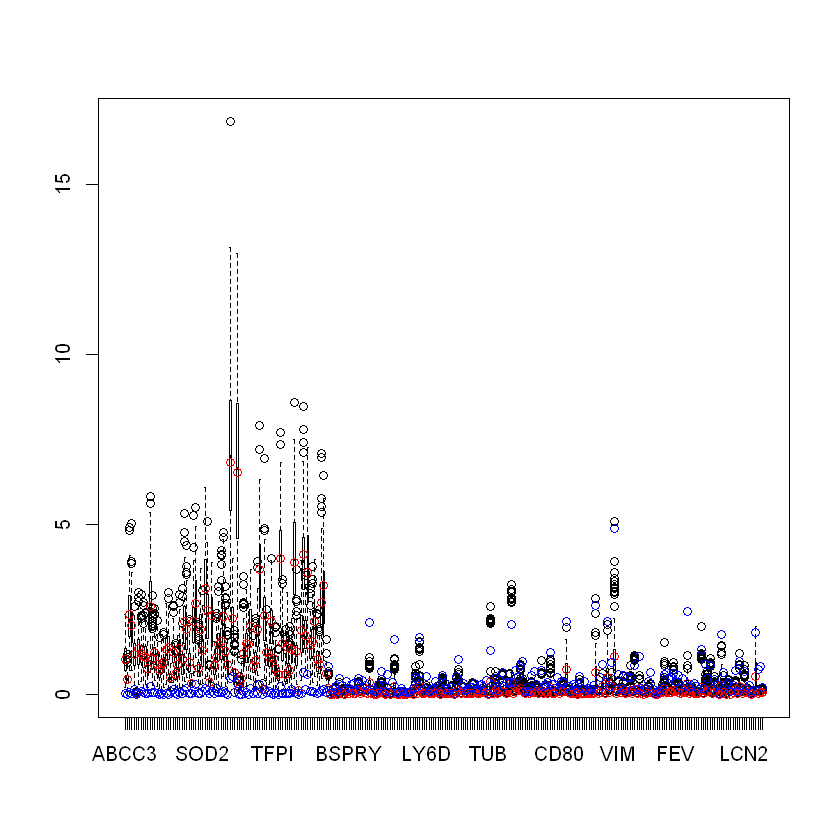

In [25]:
library(data.table)
data=read.table(paste0(root,'Rawdata/bootstrap_compiled_corrected.txt'))
var_ci=apply(data[,-1],1,var)
datac=read.table('bootstrap.txt')
var_mat=matrix(var_ci,nrow=dim(datac)[1])
setwd("C:/Users/harold/Desktop/TCGA/lioness")
# exprs_normal=read.table('GBM_unranked_normal.txt',row.names = 1)
# exprs_classical=read.table('GBM_unranked_classical.txt',row.names = 1)
# var_n=apply(exprs_normal,1,var)
# var_c=apply(exprs_classical,1,var)
result=cbind(var_c,var_mat)#
# result=var_mat
sig.names=as.vector(unlist(read.table('signames.txt')))
result_sig=result[sig.names,]
boxplot(t(result_sig[,-1]),xlab=F)
points(var_c[sig.names],col='red')
points(var_n[sig.names],col='blue')

In [ ]:
n=0
for (name in sig.names){
  if (var_n[name]<quantile(result[name,],c(0.975))
      &&var_n[name]>quantile(result[name,],c(0.025))){
    
  }
  else{
    # print(name)
    n=n+1
  }

}
print(n)             # number of normal variance falling within the center 95%

## Run topGO on 280 highly variable genes

In [4]:
source(paste0(rootdir,"/topgo/topgo.R"))

Bioconductor version 3.0 (BiocInstaller 1.16.5), ?biocLite for help
A new version of Bioconductor is available after installing the most recent
  version of R; see http://bioconductor.org/install
BioC_mirror: http://bioconductor.org
Using Bioconductor version 3.0 (BiocInstaller 1.16.5), R version 3.1.3.
Installing package(s) 'topGO'


package 'topGO' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\awacs\AppData\Local\Temp\RtmpaquNi7\downloaded_packages


Old packages: 'base64enc', 'BH', 'Cairo', 'checkmate', 'coda', 'data.table',
  'e1071', 'evaluate', 'fail', 'ggplot2', 'glmnet', 'gridExtra', 'gridSVG',
  'Hmisc', 'httr', 'installr', 'jsonlite', 'latticeExtra', 'lintr', 'lme4',
  'LMest', 'lpSolve', 'manipulate', 'MASS', 'matrixStats', 'mclust',
  'MCMCpack', 'memoise', 'mime', 'MultiLCIRT', 'mvtnorm', 'pbkrtest',
  'pheatmap', 'plotrix', 'quantreg', 'R6', 'RCircos', 'RcppArmadillo',
  'RcppEigen', 'RCurl', 'rstudioapi', 'SparseM', 'squash', 'VGAM', 'XML',
  'base64enc', 'BH', 'boot', 'car', 'caret', 'chron', 'class', 'cluster',
  'codetools', 'colorspace', 'data.table', 'digest', 'dplyr', 'evaluate',
  'foreach', 'foreign', 'formatR', 'ggplot2', 'glmnet', 'gtable', 'gtools',
  'hexbin', 'highr', 'htmltools', 'htmlwidgets', 'httpuv', 'iterators',
  'jsonlite', 'KernSmooth', 'knitr', 'lattice', 'lme4', 'maps', 'MASS',
  'Matrix', 'mgcv', 'mime', 'munsell', 'nlme', 'nnet', 'pbkrtest', 'plyr',
  'quantreg', 'R6', 'randomForest', 'rbokeh'

package 'Rgraphviz' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\awacs\AppData\Local\Temp\RtmpaquNi7\downloaded_packages


Old packages: 'base64enc', 'BH', 'Cairo', 'checkmate', 'coda', 'data.table',
  'e1071', 'evaluate', 'fail', 'ggplot2', 'glmnet', 'gridExtra', 'gridSVG',
  'Hmisc', 'httr', 'installr', 'jsonlite', 'latticeExtra', 'lintr', 'lme4',
  'LMest', 'lpSolve', 'manipulate', 'MASS', 'matrixStats', 'mclust',
  'MCMCpack', 'memoise', 'mime', 'MultiLCIRT', 'mvtnorm', 'pbkrtest',
  'pheatmap', 'plotrix', 'quantreg', 'R6', 'RCircos', 'RcppArmadillo',
  'RcppEigen', 'RCurl', 'rstudioapi', 'SparseM', 'squash', 'VGAM', 'XML',
  'base64enc', 'BH', 'boot', 'car', 'caret', 'chron', 'class', 'cluster',
  'codetools', 'colorspace', 'data.table', 'digest', 'dplyr', 'evaluate',
  'foreach', 'foreign', 'formatR', 'ggplot2', 'glmnet', 'gtable', 'gtools',
  'hexbin', 'highr', 'htmltools', 'htmlwidgets', 'httpuv', 'iterators',
  'jsonlite', 'KernSmooth', 'knitr', 'lattice', 'lme4', 'maps', 'MASS',
  'Matrix', 'mgcv', 'mime', 'munsell', 'nlme', 'nnet', 'pbkrtest', 'plyr',
  'quantreg', 'R6', 'randomForest', 'rbokeh'


The downloaded binary packages are in
	C:\Users\awacs\AppData\Local\Temp\RtmpaquNi7\downloaded_packages


Old packages: 'base64enc', 'BH', 'Cairo', 'checkmate', 'coda', 'data.table',
  'e1071', 'evaluate', 'fail', 'ggplot2', 'glmnet', 'gridExtra', 'gridSVG',
  'Hmisc', 'httr', 'installr', 'jsonlite', 'latticeExtra', 'lintr', 'lme4',
  'LMest', 'lpSolve', 'manipulate', 'MASS', 'matrixStats', 'mclust',
  'MCMCpack', 'memoise', 'mime', 'MultiLCIRT', 'mvtnorm', 'pbkrtest',
  'pheatmap', 'plotrix', 'quantreg', 'R6', 'RCircos', 'RcppArmadillo',
  'RcppEigen', 'RCurl', 'rstudioapi', 'SparseM', 'squash', 'VGAM', 'XML',
  'base64enc', 'BH', 'boot', 'car', 'caret', 'chron', 'class', 'cluster',
  'codetools', 'colorspace', 'data.table', 'digest', 'dplyr', 'evaluate',
  'foreach', 'foreign', 'formatR', 'ggplot2', 'glmnet', 'gtable', 'gtools',
  'hexbin', 'highr', 'htmltools', 'htmlwidgets', 'httpuv', 'iterators',
  'jsonlite', 'KernSmooth', 'knitr', 'lattice', 'lme4', 'maps', 'MASS',
  'Matrix', 'mgcv', 'mime', 'munsell', 'nlme', 'nnet', 'pbkrtest', 'plyr',
  'quantreg', 'R6', 'randomForest', 'rbokeh'


groupGOTerms: 	GOBPTerm, GOMFTerm, GOCCTerm environments built.



Attaching package: 'topGO'

The following objects are masked from 'package:IRanges':

    members, score, score<-

Loading required package: grid

Attaching package: 'grid'

The following object is masked from 'package:topGO':

    depth





Building most specific GOs .....	( 9246 GO terms found. )

Build GO DAG topology ..........	( 12670 GO terms and 29496 relations. )

Annotating nodes ...............	( 10719 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 3789 nontrivial nodes
		 parameters: 
			 test statistic:  fisher 

			 -- Weight Algorithm -- 

		 The algorithm is scoring 3789 nontrivial nodes
		 parameters: 
			 test statistic:  fisher : ratio 

	 Level 19:	1 nodes to be scored.

	 Level 18:	5 nodes to be scored.

	 Level 17:	10 nodes to be scored.

	 Level 16:	16 nodes to be scored.

	 Level 15:	28 nodes to be scored.

	 Level 14:	52 nodes to be scored.

	 Level 13:	113 nodes to be scored.

	 Level 12:	175 nodes to be scored.

	 Level 11:	288 nodes to be scored.

	 Level 10:	407 nodes to be scored.

	 Level 9:	477 nodes to be scored.

	 Level 8:	541 nodes to be scored.

	 Level 7:	550 nodes to be scored.

	 Level 6:	498 nodes to be scored.

	 Level 5:	361 nodes to 

In [42]:
setwd(rootdir)

## Build Networks

### Cancer Network community detection and core score enrichment

In [45]:
library(condor)
library(igraph)
elis=read.table(paste0(rootdir,'/Rawdata/classical.txt'))
elis=data.frame(elis)
elis=elis[elis[,3]==1,]
elis=elis[,c(1,2,5)]
elis[,3]=log(exp(elis[,3])+1)
elis=elis[,c(2,1,3)]
colnames(elis)=c('genes','tf','weight')
condor.object <- create.condor.object(elis)
condor.object <- condor.cluster(condor.object,project=F)
# condor.object <- condor.qscore(condor.object)
condor.object <- condor.qscore.modified(condor.object)

q_cancer <- condor.object$qscores$red.qscore


Weights detected. Building condor object with weighted edges.


[1] "modularity of projected graph 0.270490752441386"
[1] "Q = 0.297538852212048"
[1] "Q = 0.297538852212048"
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000


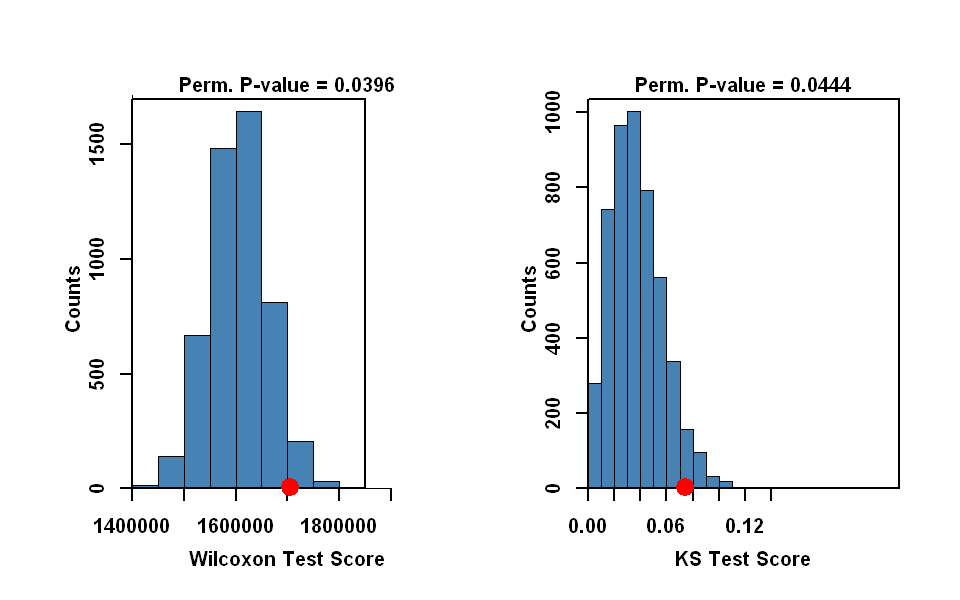

In [41]:
options(repr.plot.width=8, repr.plot.height=5)
core_stats_cancer <- condor.core.enrich(test_nodes=sig.names,
                                 q=q_cancer,perm=TRUE,plot.hist=T,nsamp=5000)

### Normal Network community detection and core score enrichment

In [48]:
elist=read.table(paste0(rootdir,'/Rawdata/normal.txt'))
elist=data.frame(elist)
elist=elist[elist[,3]==1,]
elist=elist[,c(1,2,5)]
elist[,3]=log(exp(elist[,3])+1)
elist=elist[,c(2,1,3)]
colnames(elist)=c('genes','tf','weight')
condor.objec <- create.condor.object(elist)
condor.objec <- condor.cluster(condor.objec,project=F)
condor.objec <- condor.qscore.modified(condor.objec)
q_normal <- condor.objec$qscores$red.qscore


Weights detected. Building condor object with weighted edges.


[1] "modularity of projected graph 0.278757686704376"
[1] "Q = 0.320616567386855"
[1] "Q = 0.320616567386855"
[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000
[1] 6000
[1] 7000
[1] 8000
[1] 9000
[1] 10000
[1] 11000


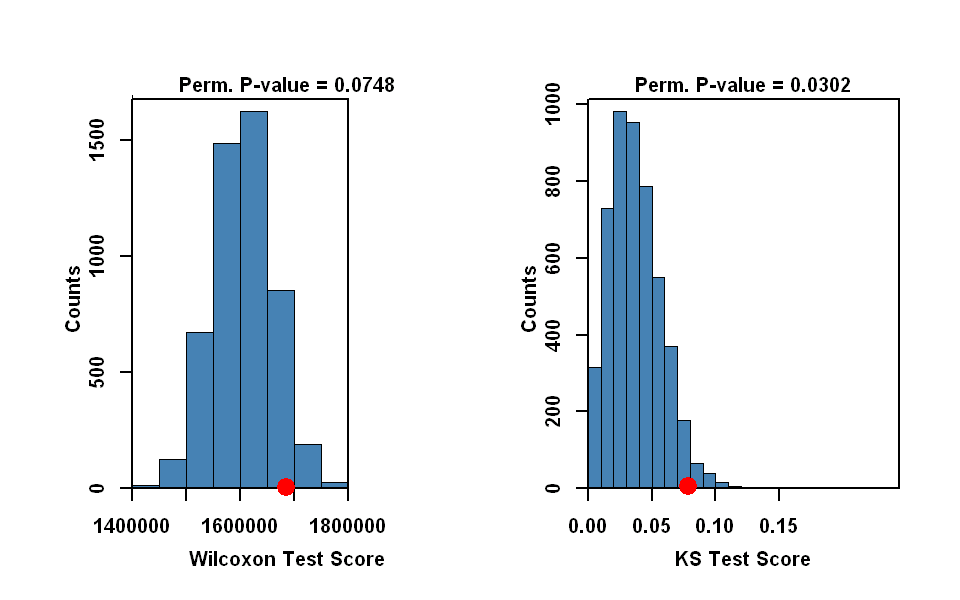

In [60]:
options(repr.plot.width=8, repr.plot.height=5)

core_stats_normal <- condor.core.enrich(test_nodes=sig.names,
                                 q=q_normal,perm=TRUE,plot.hist=TRUE,nsamp=5000)

In [49]:
colnames(elis)=c('genes','tf','weight')
cancer_network=graph.data.frame(elis)
gene_degree_cancer=graph.strength(cancer_network,mode='out')
gene_degree_cancer=gene_degree_cancer[gene_degree_cancer!=0]
# length(gene_degree_cancer)
hidegree.cancer = names(sort(gene_degree_cancer,decreasing = T)[1:100])
hidegree.cancer
colnames(elist)=c('genes','tf','weight')
normal_network=graph.data.frame(elist)
gene_degree_normal=graph.strength(normal_network,mode='out')
gene_degree_normal=gene_degree_normal[gene_degree_normal!=0]
length(gene_degree_normal)
hidegree.normal = names(sort(gene_degree_normal,decreasing = T)[1:100])
degree_diff=gene_degree_cancer-gene_degree_normal

[1] "SYNE1"     "DMD"       "SLC13A3"   "DICER1"    "ITSN1"     "RIMS1"    
  [7] "AKAP13"    "SYNE2"     "UBR4"      "KANK1"     "ABLIM1"    "RAPGEF4"  
 [13] "KTN1"      "FAH"       "LPP"       "CCDC88A"   "CHD9"      "NCOR1"    
 [19] "KIAA1109"  "ANK3"      "HDAC9"     "MID1"      "GREB1"     "DOCK9"    
 [25] "ARID1A"    "PLXNB1"    "DST"       "TCF4"      "BAZ2B"     "MPDZ"     
 [31] "TNS1"      "CLASP2"    "DDX42"     "GAS7"      "NEDD4L"    "PRMT8"    
 [37] "ECM2"      "SORBS2"    "ANAPC5"    "BDNF"      "ATP9B"     "APBB1"    
 [43] "ZNF638"    "PTK2"      "ZHX3"      "NAV2"      "EPB41L2"   "PPFIBP2"  
 [49] "SPG20"     "KIFC3"     "PRRC2B"    "CPEB1"     "CLASP1"    "AHCYL1"   
 [55] "IFRD1"     "ARHGAP32"  "PTPRR"     "MICAL2"    "DOCK10"    "MYO15A"   
 [61] "ZNF280D"   "KALRN"     "CNTRL"     "C2CD2"     "SIK3"      "PUM2"     
 [67] "DLEC1"     "ANKRD28"   "TFR2"      "DEPDC5"    "TFEB"      "HELZ"     
 [73] "WDFY3"     "UNC45A"    "CALD1"     "CAST"      "BNC2"      "KIAA0319L"
 [79] "AEN"       "GCNT1"     "ATM"       "HIPK1"     "DMXL2"     "TJP2"     
 [85] "KCNMA1"    "SLC12A1"   "TMPRSS3"   "FGFR2"     "PLS3"      "CREM"     
 [91] "GHR"       "ACACA"     "HLA-DRB1"  "WWC2"      "SPATA7"    "TGIF1"    
 [97] "ARHGEF7"   "SUN1"      "GIGYF2"    "OSBP"

[1] 11747

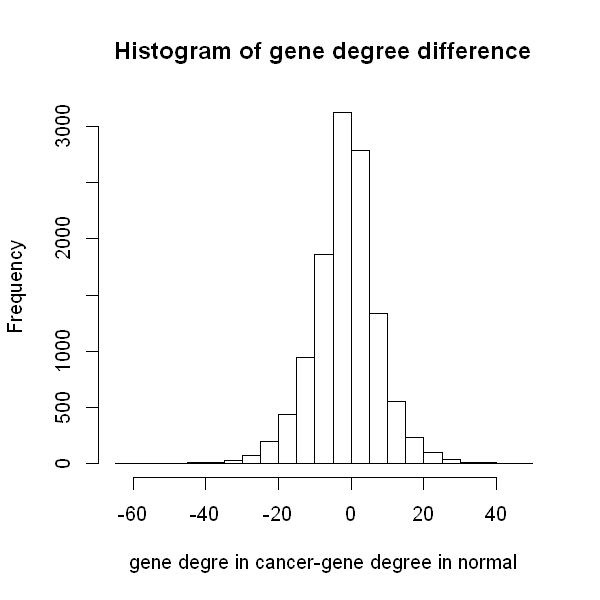

In [53]:
options(repr.plot.width=5, repr.plot.height=5)
hist(degree_diff[,2],breaks=20, main='Histogram of gene degree difference', xlab='gene degre in cancer-gene degree in normal')

## Gene set enrichment

In [34]:
########
# Vdiff GSEA
#############
setwd(rootdir)
write.table(sort(vdiff),file='vdiff.rnk',quote=F,row.names=T,col.names=F,sep='\t')
dir.create("gsea/vdiff",recursive = T,showWarnings=F)
gsea<-"java -Xmx1024m -cp gsea2-2.0.13.jar xtools.gsea.GseaPreranked -gmx c2.cp.reactome.v5.0.symbols.gmt 
-collapse false -mode Max_probe -norm meandiv -nperm 1000 -rnk ./vdiff.rnk -scoring_scheme weighted 
-rpt_label gsea_c2.cp.reactome -include_only_symbols true -make_sets true -plot_top_x 7000 -rnd_seed timestamp 
-set_max 250 -set_min 1 -zip_report false -out ./gsea/vdiff -gui false"
system(gsea)
setwd('./gsea/vdiff')
gseadir <- list.files(pattern=".GseaPreranked")
setwd(gseadir)
gseafiles <- list.files(pattern="gsea_report") # gsea outputs .html and .xls files for signatures with positive and negative enrichment scores
neg <- read.delim(gseafiles[2]) # signatures with negative enrichment scores
pos <- read.delim(gseafiles[4]) # signatures with positive enrichment scores
gsea <- rbind(neg, pos) # combine the signatures
dat <- gsea[,c(1,4,5,8)] # keep these columns (contain signature name, size, nominal p-value, and FDR)
dat <- dat[order(as.character(dat[,1])),] # order the signatures alphabetically
dat<-dat[order(dat$FDR.q.val),]
setwd(paste0(rootdir,'/gsea/vdiff'))
write.table(dat,file='vdiff.gsea')
setwd(rootdir)

## Community structure comparison

In [63]:
com_normal=condor.objec
com_cancer=condor.object
nmax=max(com_normal$red.memb[,2])
cmax=max(com_cancer$red.memb[,2])

esult=matrix(0,nrow=nmax,ncol=cmax)              # intersection matrix
for (i in 1:nmax){
  for (j in 1:cmax){
    esult[i,j]=length(intersect(as.vector(com_normal$red.memb[com_normal$red.memb[,2]==i,1]),
                                as.vector(com_cancer$red.memb[com_cancer$red.memb[,2]==j,1])))
    
  }
}
# rowmax=c()
# for (i in 1:17){
#     index_max=which.max(esult[i,])
#     rowmax=c(rowmax,index_max)
# }
# esult=esult[,rowmax]
# percentage=c()
# for (i in 1:17){
#   maxr=max(esult[i,])
#   sumr=sum(esult[i,])
#   ratio=maxr/sumr
#   percentage=c(percentage,ratio)
# }
# matrix=cbind(esult,percentage)

# nmax=15
# cmax=18
# com_normal_s=com_normal$red.memb[com_normal$red.memb$red.names %in% as.vector(sig.names),]
# com_cancer_s=com_cancer$red.memb[com_cancer$red.memb$red.names %in% as.vector(sig.names),]
# Result=matrix(0,nrow=nmax,ncol=cmax)
# for (i in 1:nmax){
#   for (j in 1:cmax){
#     Result[i,j]=length(intersect(as.vector(com_normal_s[com_normal_s[,2]==i,1]),as.vector(com_cancer_s[com_cancer_s[,2]==j,1])))
    
#   }
# }
# final=data.frame(0,nrow=nmax,ncol=cmax)
# for (i in 1:nmax){
#   for (j in 1:cmax){
#     if (Result[i,j]==0){
#       final[i,j]=esult[i,j]
#     }
#     else{
#       final[i,j]=paste(Result[i,j],esult[i,j],sep='/')
#     }
    
#   }
# }


In [64]:
jaccard <- function(m) {
    ## common values:
    nrow=dim(m)[1]
    ncol=dim(m)[2]
    Result=matrix(0,nrow=nrow,ncol=ncol)
    for (i in 1:nrow){
        for (j in 1:ncol){
            Result[i,j]=m[i,j]/(sum(m[i,])+sum(m[,j])-m[i,j])
        }
    }
    return(Result)
}

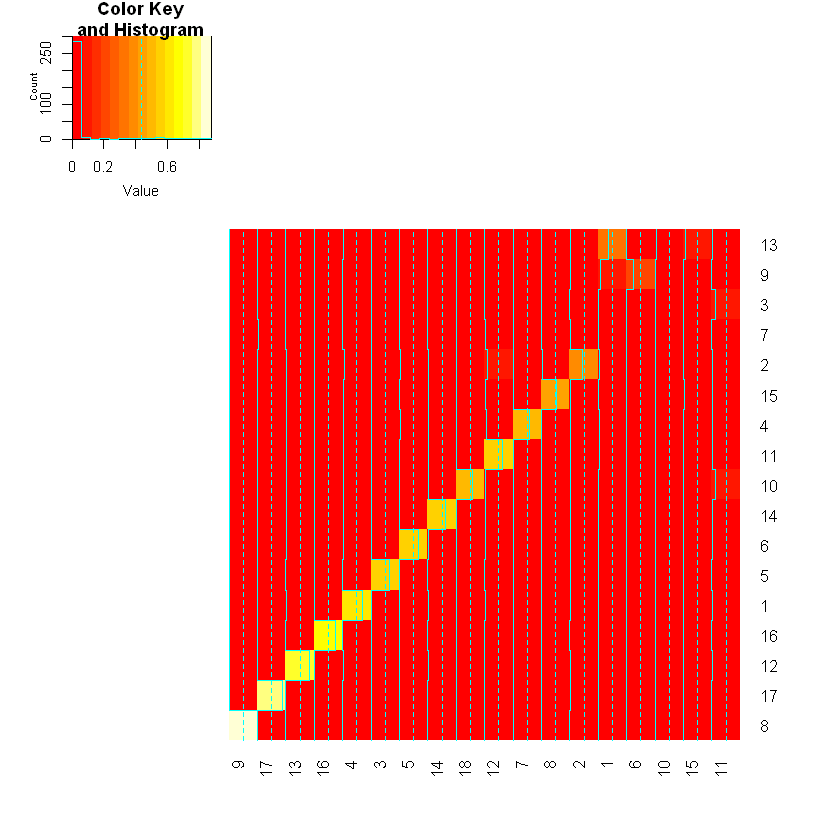

In [85]:
library(gplots)
mat= matrix(c(1,0,0,1),nrow=2)
heat=jaccard(as.matrix(esult))
y=heatmap.2(heat,dendrogram = 'none')

## Plot of abs gene degree difference vs -log10 of Levene FDR 

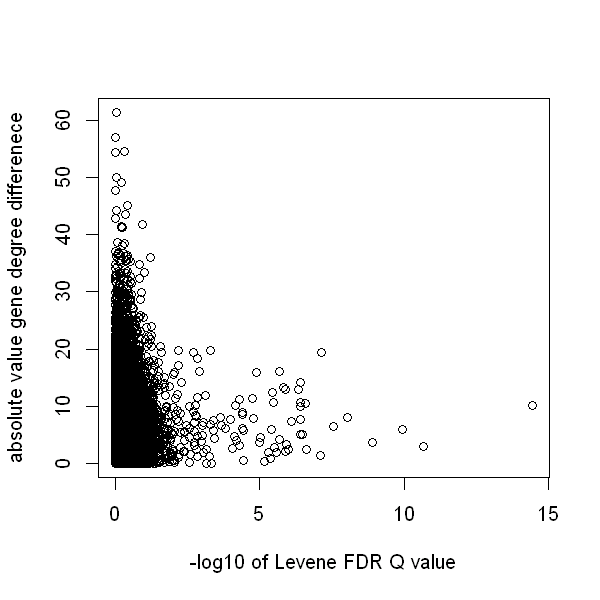

In [53]:
genenames=names(fdr.result)
options(repr.plot.width=5, repr.plot.height=5)
plot(-log10(fdr.result[genenames]),abs(degree_diff[genenames])
     ,xlab='-log10 of Levene FDR Q value', ylab='absolute value gene degree differenece')

## Core score vs Levene q value, log scale

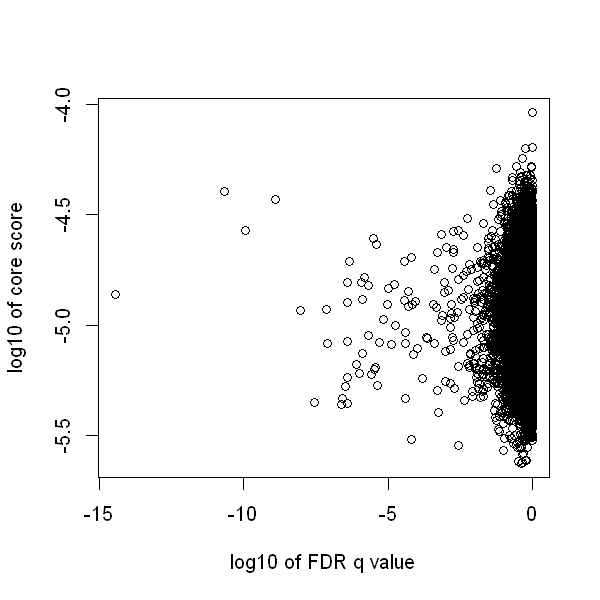

In [19]:
options(repr.plot.width=5, repr.plot.height=5)
plot(log10(fdr.result[com_cancer$qscores$red.qscore$red.names]), log10(com_cancer$qscores$red.qscore[,3]),xlab='log10 of FDR q value',ylab='log10 of core score')

## Mean Variance relationship

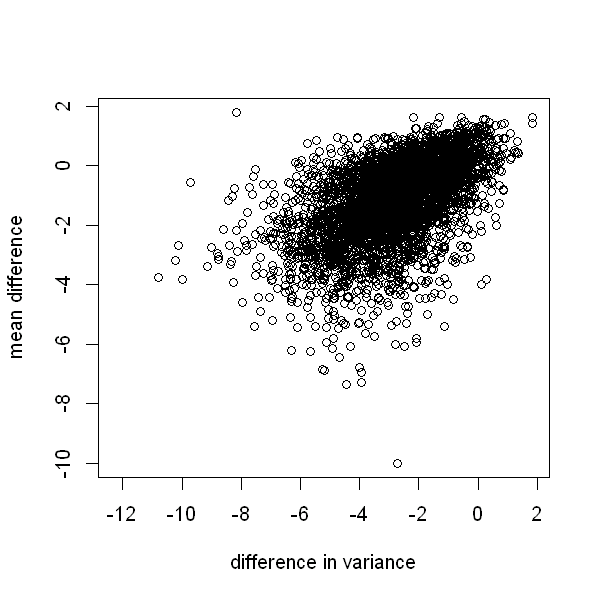

In [55]:
options(repr.plot.width=5, repr.plot.height=5)
# plot(log(var_c-var_n),log(mean_c-mean_n))
plot(log(var_c-var_n),log(mean_c-mean_n),xlab='difference in variance',ylab='mean difference')

In [56]:
source("http://bioconductor.org/biocLite.R")
biocLite("limma")
library(limma)
design<-c(rep(0,dim(exprs_normal)[2]),rep(1,dim(exprs_classical)[2]))
design.mat<-model.matrix(~design)
fit <- lmFit(cbind(exprs_normal,exprs_classical), design.mat)
fit <- eBayes(fit)
topTable(fit, coef = "design") #To specify which term we want to look at
genes_c_280=rownames(topTable(fit, coef = "design")[1:280,])        # highest 280 diff expressed genes

Bioconductor version 3.0 (BiocInstaller 1.16.5), ?biocLite for help
A new version of Bioconductor is available after installing the most recent
  version of R; see http://bioconductor.org/install
BioC_mirror: http://bioconductor.org
Using Bioconductor version 3.0 (BiocInstaller 1.16.5), R version 3.1.3.
Installing package(s) 'limma'


package 'limma' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\awacs\AppData\Local\Temp\RtmpaquNi7\downloaded_packages


Old packages: 'base64enc', 'BH', 'Cairo', 'checkmate', 'coda', 'data.table',
  'e1071', 'evaluate', 'fail', 'ggplot2', 'glmnet', 'gridExtra', 'gridSVG',
  'Hmisc', 'httr', 'installr', 'jsonlite', 'latticeExtra', 'lintr', 'lme4',
  'LMest', 'lpSolve', 'manipulate', 'MASS', 'matrixStats', 'mclust',
  'MCMCpack', 'memoise', 'mime', 'MultiLCIRT', 'mvtnorm', 'pbkrtest',
  'pheatmap', 'plotrix', 'quantreg', 'R6', 'RCircos', 'RcppArmadillo',
  'RcppEigen', 'RCurl', 'rstudioapi', 'SparseM', 'squash', 'VGAM', 'XML',
  'base64enc', 'BH', 'boot', 'car', 'caret', 'chron', 'class', 'cluster',
  'codetools', 'colorspace', 'data.table', 'digest', 'dplyr', 'evaluate',
  'foreach', 'foreign', 'formatR', 'ggplot2', 'glmnet', 'gtable', 'gtools',
  'hexbin', 'highr', 'htmltools', 'htmlwidgets', 'httpuv', 'iterators',
  'jsonlite', 'KernSmooth', 'knitr', 'lattice', 'lme4', 'maps', 'MASS',
  'Matrix', 'mgcv', 'mime', 'munsell', 'nlme', 'nnet', 'pbkrtest', 'plyr',
  'quantreg', 'R6', 'randomForest', 'rbokeh'

,logFC,AveExpr,t,P.Value,adj.P.Val,B
CCKBR,-3.592761,4.563984,-41.47297,1.290697e-85,1.516182e-81,184.9136
ANO3,-4.595383,4.298138,-41.21093,3.169089e-85,1.861364e-81,184.0253
NEUROD6,-2.710675,5.24542,-37.4732,2.000892e-79,7.834825e-76,170.7993
CAMKV,-3.869018,4.726555,-37.07685,8.780687e-79,2.578668e-75,169.3327
CNKSR2,-3.679762,4.890403,-36.66218,4.182271e-78,9.825827e-75,167.7844
SLC30A3,-3.667793,5.327611,-36.5141,7.327696e-78,1.434641e-74,167.2281
KHDRBS2,-3.034856,4.360255,-35.63489,2.12508e-76,3.566188e-73,163.8864
RYR2,-3.091898,4.536946,-35.15911,1.350861e-75,1.98357e-72,162.0502
SYN2,-4.24362,4.813911,-34.78199,5.933497e-75,7.744532e-72,160.5806
CACNG3,-5.014803,4.652693,-34.52343,1.648544e-74,1.936545e-71,159.5656


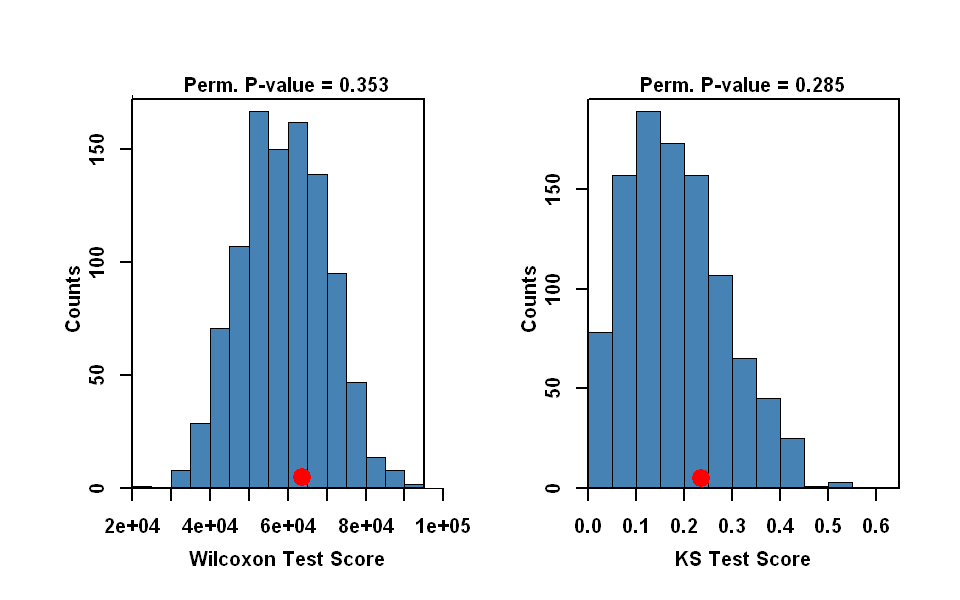

In [57]:
options(repr.plot.width=8, repr.plot.height=5)
core_stats_cancer <- condor.core.enrich(test_nodes=genes_c_280,
                                 q=q_cancer,perm=TRUE,plot.hist=T)

### Degree difference vs core scores

In [59]:
hidegree_diff=names(sort(abs(degree_diff),decreasing=T)[1:280])

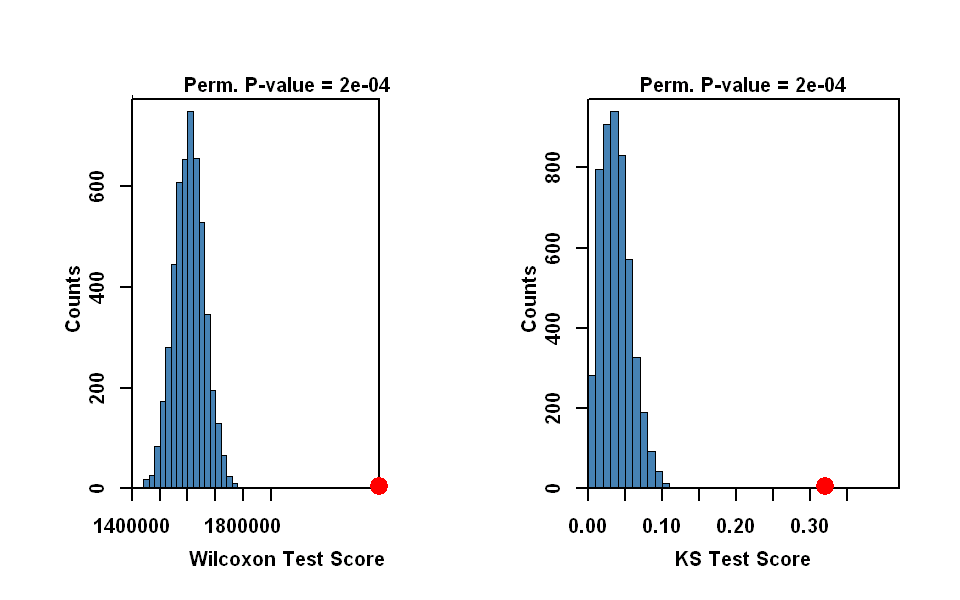

In [149]:
options(repr.plot.width=8, repr.plot.height=5)
core_stats_cancer <- condor.core.enrich(test_nodes=hidegree_diff,
                                 q=q_cancer,perm=TRUE,plot.hist=T,nsamp=5000)


## degree difference vs Levene FDR Q Value

In [175]:
v_normal=q_normal
v_normal[,3]=degree_diff[v_normal$red.names]
v_normal[1:10,]

,red.names,com,Qik
1,A1CF,11,-4.452031
2,A2M,4,-5.410236
3,A4GALT,13,6.482179
4,A4GNT,1,-18.81719
5,AAAS,2,6.462015
6,AACS,11,7.967878
7,AADAC,11,-20.21133
8,AAGAB,11,-11.44766
9,AAK1,12,1.458982
10,AAMDC,11,1.63218


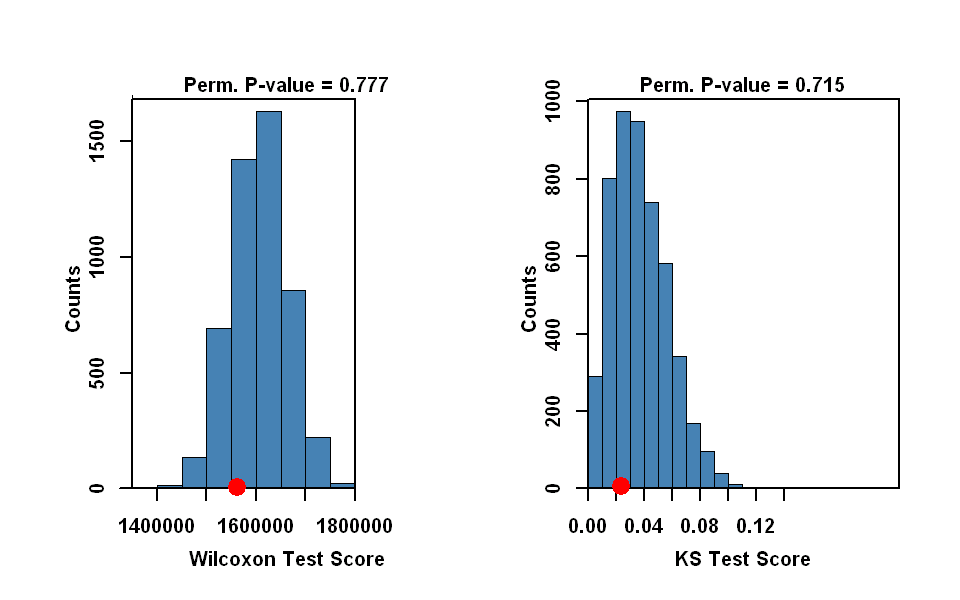

In [176]:
v_normal=q_normal
v_normal[,3]=degree_diff[v_normal$red.names]
core_stats_normal <- condor.core.enrich(test_nodes=sig.names,
                                 q=v_normal,perm=TRUE,plot.hist=TRUE,nsamp=5000)

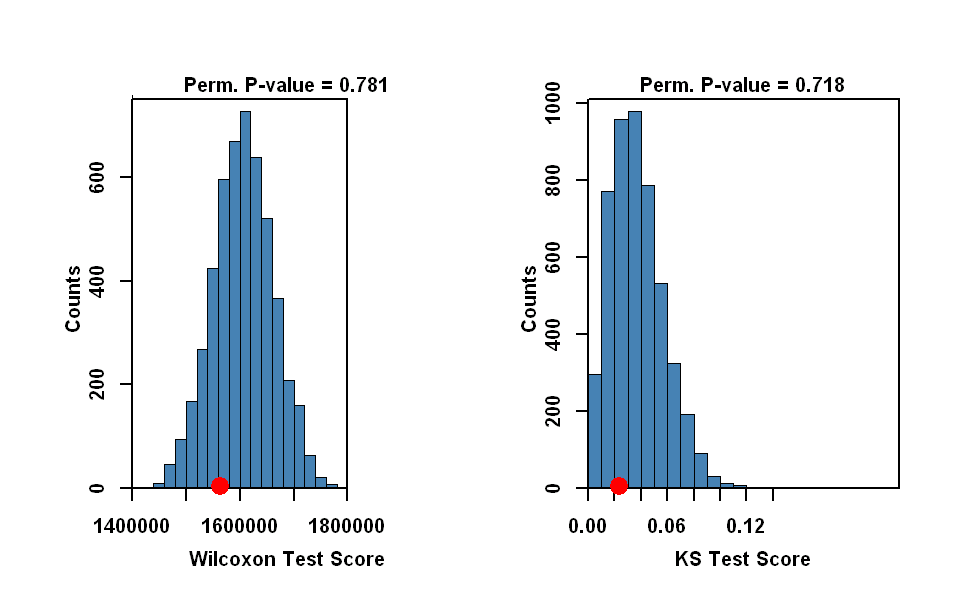

In [177]:
v_cancer=q_cancer
v_cancer[,3]=degree_diff[v_cancer$red.names]
core_stats_normal <- condor.core.enrich(test_nodes=sig.names,
                                 q=v_cancer,perm=TRUE,plot.hist=TRUE,nsamp=5000)

## Old code and old results

In [197]:
highcore=as.vector(q_cancer[order(q_cancer$Qik,decreasing=TRUE),]$red.names[1:200])

In [3]:
load('GBMcommunity.dat')

In [48]:
esult=read.table('communities.txt')
heat=as.matrix(vegdist(esult,method = 'jaccard',diag=T,upper=T))

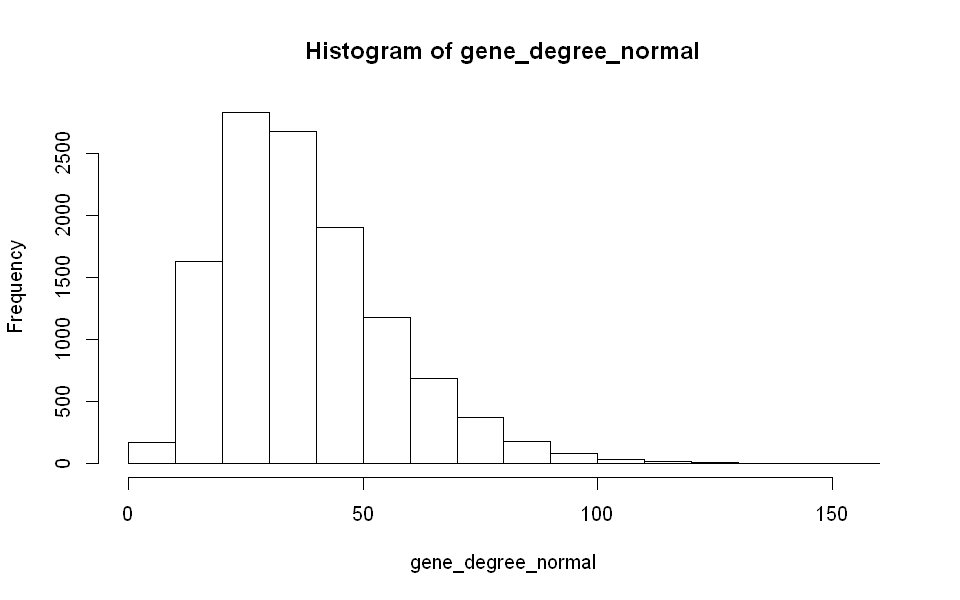

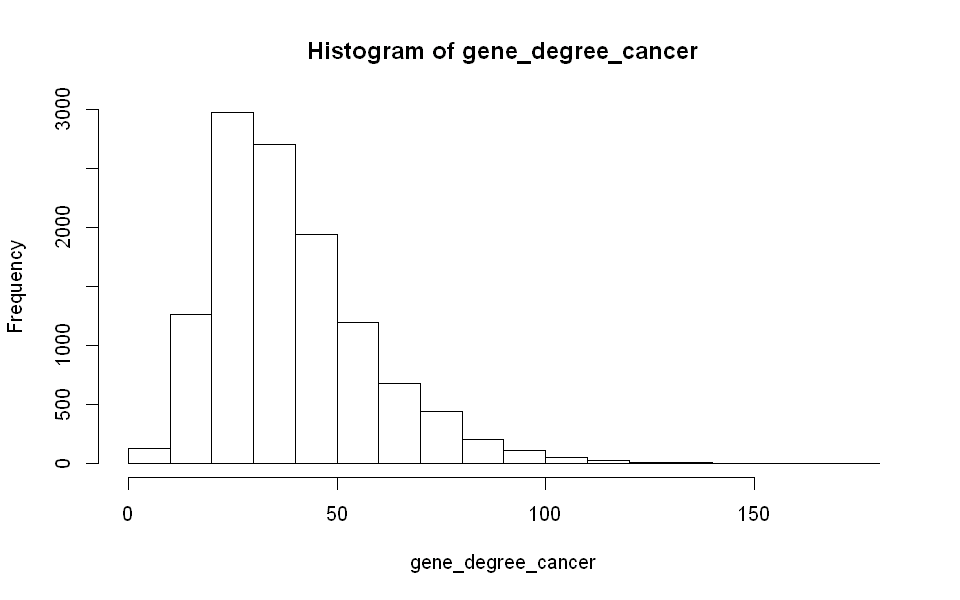

In [157]:
hist(gene_degree_normal)
hist(gene_degree_cancer)

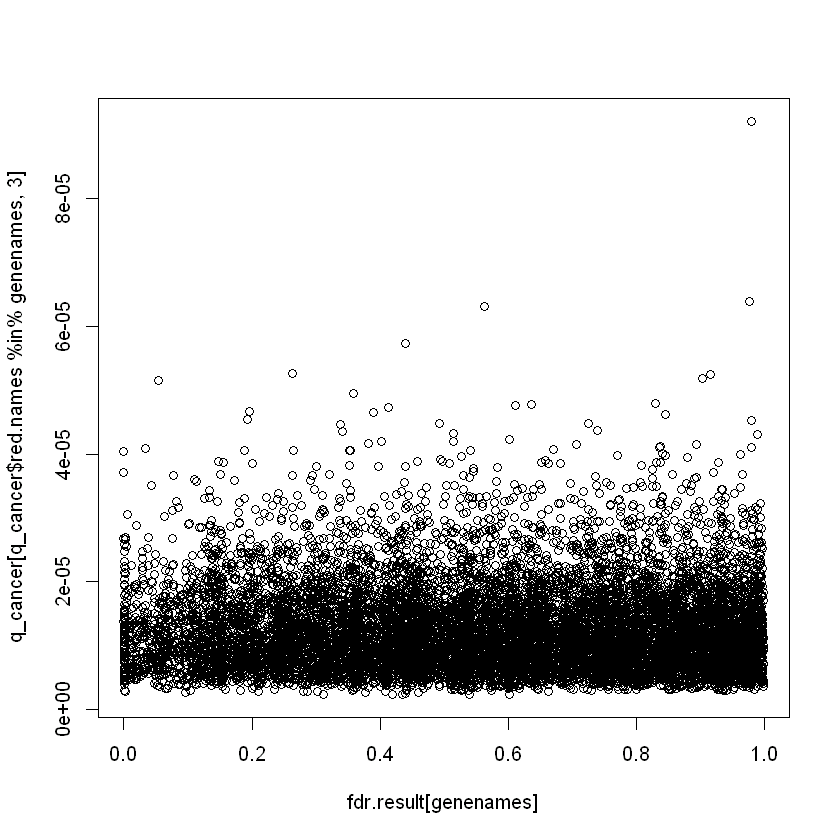

In [125]:
plot(fdr.result[genenames], q_cancer[q_cancer$red.names %in% genenames,3])

In [44]:
gene_degree_diff=read.table('degree_diff.rnk')

In [54]:
# GSEA Analysis on differential gene degree between classical GBM andd normal
gene_degree_diff=gene_degree_cancer-gene_degree_normal
write.table(gene_degree_diff,file='degree_diff.rnk',quote=F,col.names = F,sep='\t')
setwd("C:/Users/harold/Desktop/TCGA/lioness")
dir.create("./degree_diff_gsea_c")
gsea<-"java -Xmx1024m -cp gsea2-2.0.13.jar xtools.gsea.GseaPreranked -gmx c2.cp.reactome.v5.0.symbols.gmt 
-collapse false -mode Max_probe -norm meandiv -nperm 1000 -rnk ./degree_diff.rnk 
-scoring_scheme weighted -rpt_label gsea_c2.cp.reactome -include_only_symbols true -make_sets true 
-plot_top_x 7000 -rnd_seed timestamp -set_max 250 -set_min 1 -zip_report false -out ./degree_diff_gsea_c -gui false"
system(gsea)

setwd("./degree_diff_gsea_c")
gseadir <- list.files(pattern=".GseaPreranked")
setwd(gseadir)
gseafiles <- list.files(pattern="gsea_report") # gsea outputs .html and .xls files for signatures with positive and negative enrichment scores
neg <- read.delim(gseafiles[2]) # signatures with negative enrichment scores
pos <- read.delim(gseafiles[4]) # signatures with positive enrichment scores
gsea <- rbind(neg, pos) # combine the signatures
dat <- gsea[,c(1,4,5,8)] # keep these columns (contain signature name, size, nominal p-value, and FDR)
dat <- dat[order(as.character(dat[,1])),] # order the signatures alphabetically
dat<-dat[order(dat$FDR.q.val),]
setwd("C:/Users/harold/Dropbox/HSPH/Quackenbush Lab/Thesis/")
write.table(dat,file='vdiff_c-n.gsea')
setwd("C:/Users/harold/Desktop/TCGA/lioness")

In [55]:
# GSEA Analysis on differential gene degree between classical GBM andd normal
gene_degree_diff=-gene_degree_cancer+gene_degree_normal
write.table(gene_degree_diff,file='degree_diff.rnk',quote=F,col.names = F,sep='\t')
setwd("C:/Users/harold/Desktop/TCGA/lioness")
dir.create("./degree_diff_gsea_n")
gsea<-"java -Xmx1024m -cp gsea2-2.0.13.jar xtools.gsea.GseaPreranked -gmx c2.cp.reactome.v5.0.symbols.gmt 
-collapse false -mode Max_probe -norm meandiv -nperm 1000 -rnk ./degree_diff.rnk 
-scoring_scheme weighted -rpt_label gsea_c2.cp.reactome -include_only_symbols true -make_sets true 
-plot_top_x 7000 -rnd_seed timestamp -set_max 250 -set_min 1 -zip_report false -out ./degree_diff_gsea_n -gui false"
system(gsea)

setwd("./degree_diff_gsea_n")
gseadir <- list.files(pattern=".GseaPreranked")
setwd(gseadir)
gseafiles <- list.files(pattern="gsea_report") # gsea outputs .html and .xls files for signatures with positive and negative enrichment scores
neg <- read.delim(gseafiles[2]) # signatures with negative enrichment scores
pos <- read.delim(gseafiles[4]) # signatures with positive enrichment scores
gsea <- rbind(neg, pos) # combine the signatures
dat <- gsea[,c(1,4,5,8)] # keep these columns (contain signature name, size, nominal p-value, and FDR)
dat <- dat[order(as.character(dat[,1])),] # order the signatures alphabetically
dat<-dat[order(dat$FDR.q.val),]
setwd("C:/Users/harold/Dropbox/HSPH/Quackenbush Lab/Thesis/")
write.table(dat,file='vdiff_n-c.gsea')
setwd("C:/Users/harold/Desktop/TCGA/lioness")
# write.table(dat,file='vdiff.gsea')

In [10]:
matcn=as.matrix(c_n$FDR.q.val)
rownames(matcn)=c_n$NAME
heatmap(matcn)

In [1]:
c_n=read.table('vdiff_c-n.gsea')
n_c=read.table('vdiff_n-c.gsea')

In [5]:
dim(c_n[c_n$FDR.q.val<0.25 & c_n$ES>0,])

[1] 42  4

In [89]:
#setwd("C:/Users/harold/Dropbox/HSPH/Quackenbush Lab/Thesis/")
write.table(matrix,file='vdiff_c-n_results.gsea',quote=F,row.names=T,col.names=F,sep='\t')
#setwd("C:/Users/harold/Desktop/TCGA/lioness")